In [1]:
import sys
sys.path.append("/home/domp/pytorch-RNNsearch")

In [2]:
import torch 
import tqdm
import torch.nn as nn 
from torch.utils.data import DataLoader
from torchtext.data.metrics import bleu_score
from dataset import prepare_data, get_iter, Collater
from rnn_attn import build_model
from config import get_cfg_defaults
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

# Helper Functions

In [4]:
def translate(
    sentence: str, 
    model: torch.nn.Module, 
    cfg, 
    max_length: int, 
    text_transform: dict, 
    vocab_transform: dict, 
    token_transform: dict, 
    device: torch.device,
    plot: bool = True,
):
    """Function to translate a sentence and plot the attention weights."""
    model.eval()
    text_tensor = text_transform[cfg.DATASET.SRC_LANGUAGE](sentence)
    text_tensor = text_tensor.unsqueeze(1).to(device)
    
    with torch.no_grad():
        out, attn = model.inference(text_tensor, max_length, cfg)
    
    pred_tokens = out.argmax(2).squeeze(1)
    pred_tokens = [t.item() for t in pred_tokens]
    
    eos = pred_tokens.index(cfg.DATASET.EOS_IDX)
    
    translation = vocab_transform[cfg.DATASET.TGT_LANGUAGE].lookup_tokens(pred_tokens[1:eos])
    
    attn = attn.squeeze(0).cpu().numpy()
    attn = attn[1:eos+1, 1:] # [tgt, src]
    
    src_tokens = token_transform[cfg.DATASET.SRC_LANGUAGE](sentence)
    tgt_tokens = token_transform[cfg.DATASET.TGT_LANGUAGE](" ".join(translation))
    
    src_tokens += ["<eos>"]
    tgt_tokens += ["<eos>"]
    
    print("TRANSLATION")
    print("="*50)
    print("SOURCE: {}".format(" ".join(src_tokens)))
    print("-"*50)
    print("PREDICTION: {}".format(" ".join(translation)))
    print("\n")
    
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(10,10))

        img = ax.matshow(attn)
        ax.set_xticks([i for i in range(len(src_tokens))])
        ax.set_yticks([i for i in range(len(tgt_tokens))])

        ax.set_xticklabels(src_tokens, rotation=90)
        ax.set_yticklabels(tgt_tokens)

In [5]:
def print_test_predictions(
    model, 
    dataloader, 
    cfg, 
    vocab_transform, 
    device, 
    max_length: int = 100, 
    num_sentences: int = 5,
):
    model.eval()
    count = 0
    for src, tgt in test_dataloader:
        print("==="*20)
        src_ = src.to(device)

        with torch.no_grad():
            pred, _ = model.inference(src_, max_length, cfg)

        pred = pred.argmax(2).squeeze(1)
        pred = [t.item() for t in pred]
        eos = pred.index(cfg.DATASET.EOS_IDX)
        pred = pred[1:eos]
        pred = vocab_transform[cfg.DATASET.TGT_LANGUAGE].lookup_tokens(pred)

        src = list(src.squeeze(1).numpy())
        tgt = list(tgt.squeeze(1).numpy())

        src = vocab_transform[cfg.DATASET.SRC_LANGUAGE].lookup_tokens(src)
        tgt = vocab_transform[cfg.DATASET.TGT_LANGUAGE].lookup_tokens(tgt)

        print("SRC:\t{}".format(" ".join(src[1:-1])))
        print("TGT:\t{}".format(" ".join(tgt[1:-1])))
        print("---"*20)
        print("PRED:\t{}".format(" ".join(pred)))

        count += 1
        if count == num_sentences:
            return

In [6]:
def bleu_score_test(
    iterator, 
    model: torch.nn.Module, 
    cfg, 
    token_transform: dict, 
    text_transform: dict,
    vocab_transform: dict,
    max_n: int = 4, 
    weights: list = [0.25, 0.25, 0.25, 0.25],
    max_length: int = 1000,
):
    """Helper function to calculate bleu score."""
    bleu_scores = []
    model.eval()

    for src, tgt in tqdm.tqdm(iterator):
        src_ = token_transform[cfg.DATASET.SRC_LANGUAGE](src)
        tgt_ = token_transform[cfg.DATASET.TGT_LANGUAGE](tgt)
        # remove stuff for bleu score (I've chosen a bad tokenizer I guess)
        src_.remove('\n')
        while ' ' in src_:
            src_.remove(' ')
        while '  ' in src_:
            src_.remove('  ')
        while '   ' in src_:
            src_.remove('   ')
        tgt_.remove('\n')
        while ' ' in tgt_:
            tgt_.remove(' ')
        while '  ' in tgt_:
            tgt_.remove('  ')
        while '   ' in tgt_:
            tgt_.remove('   ')

        text_tensor = text_transform[cfg.DATASET.SRC_LANGUAGE](src)
        text_tensor = text_tensor.unsqueeze(1).to(device)

        with torch.no_grad():
            out, _ = model.inference(text_tensor, max_length, cfg)

        pred_tokens = out.argmax(2).squeeze(1)
        pred_tokens = [t.item() for t in pred_tokens]

        eos = pred_tokens.index(cfg.DATASET.EOS_IDX)
        pred_tokens_ = pred_tokens[1:eos]

        translation = vocab_transform[cfg.DATASET.TGT_LANGUAGE].lookup_tokens(pred_tokens_)

        while ' ' in translation:
            translation.remove(' ')
        while '  ' in translation:
            translation.remove('  ')
        while '   ' in translation:
            translation.remove('   ')

        candidate = [translation]
        refs = [[tgt_]]

        bscore = bleu_score(candidate, refs, max_n=max_n, weights=weights)
        bleu_scores.append(bscore)
        
    return round(sum(bleu_scores) / len(bleu_scores) * 100, 2)

In [7]:
# put your paths here
checkpoint_path = "/home/domp/pytorch-RNNsearch/experiments/2021-11-21_IWSLT2017/best.pth"
config_path = "/home/domp/pytorch-RNNsearch/experiments/2021-11-21_IWSLT2017/config.yaml"

In [8]:
cfg = get_cfg_defaults()
cfg.merge_from_file(config_path)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(1)

In [10]:
token_transform, vocab_transform, text_transform = prepare_data(cfg)

Length of vocab [de - IWSLT2017]: 16713
Length of vocab [en - IWSLT2017]: 14016


In [11]:
model = build_model(cfg, vocab_transform, device, checkpoint_path)
model.eval()

Load model checkpoint: /home/domp/pytorch-RNNsearch/experiments/2021-11-21_IWSLT2017/best.pth


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(16713, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(14016, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=14016, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [12]:
criterion = nn.CrossEntropyLoss(ignore_index=cfg.DATASET.PAD_IDX)
collater = Collater(cfg, text_transform)

In [13]:
test_iter = get_iter(cfg, split="test")

In [14]:
test_dataloader = DataLoader(test_iter, batch_size=1, collate_fn=collater, pin_memory=True)

In [15]:
print_test_predictions(model, test_dataloader, cfg, vocab_transform, device, max_length=100, num_sentences=7)

SRC:	Vor einigen Jahren , hier bei TED , stellte Peter unk einen unk namens " Die unk " vor .
TGT:	Several years ago here at TED , Peter unk   introduced a design challenge   called the marshmallow challenge .
------------------------------------------------------------
PRED:	A couple years ago , at TED TED , Peter Peter unk a unk called " The unk unk . "
SRC:	Die Idee ist ziemlich einfach . unk müssen die unk unk Struktur mit 20 unk , ca. 1 m Klebeband , ca. 1 m Faden und einem Marshmallow bauen .
TGT:	And the idea 's pretty simple :   unk of four have to build the tallest free - standing structure   out of 20 sticks of spaghetti ,   one yard of tape , one yard of string   and a marshmallow .
------------------------------------------------------------
PRED:	And the idea is pretty simple . unk , to have to unk the unk unk structure of 20 - 20 - , , about a a mile , about a a of a .
SRC:	Der Marshmallow muss oben drauf sein .
TGT:	The marshmallow has to be on top .
--------------------

TRANSLATION
SOURCE: Mein Name ist Johann Gerberding und ich programmiere sehr gern und trainiere gern Machine Learning Modelle . <eos>
--------------------------------------------------
PREDICTION: My name is unk unk , and I love like very unk and unk unk to unk models .




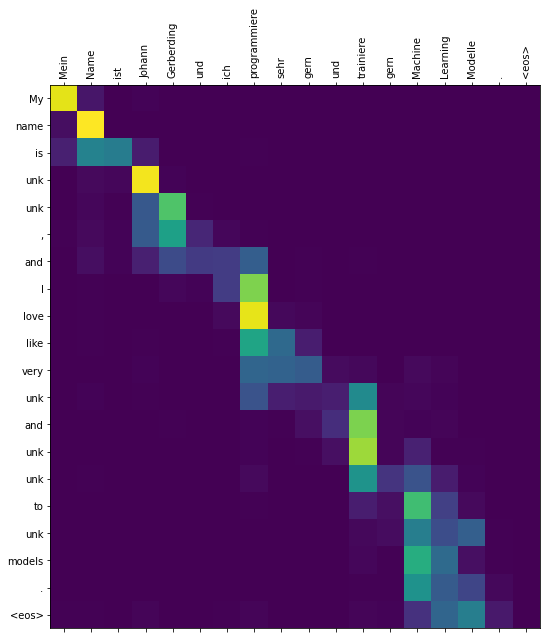

In [16]:
translate(
    "Mein Name ist Johann Gerberding und ich programmiere sehr gern und trainiere gern Machine Learning Modelle.",
    model,
    cfg, 
    100,
    text_transform,
    vocab_transform, 
    token_transform,
    device,
)

In [17]:
sentences = [
    "Er liebt Bücher und gutes Essen mehr als alles andere.", 
    "Mathematik und Physik waren seine liebsten Fächer in der Schule.",
    "Peter liebt es mit dem Fahrrad zur Arbeit zu fahren.",
    "Künstliche Intelligenz und programmieren macht einfach Spaß.",
]

TRANSLATION
SOURCE: Er liebt Bücher und gutes Essen mehr als alles andere . <eos>
--------------------------------------------------
PREDICTION: He loves books and and food food more than anything else .




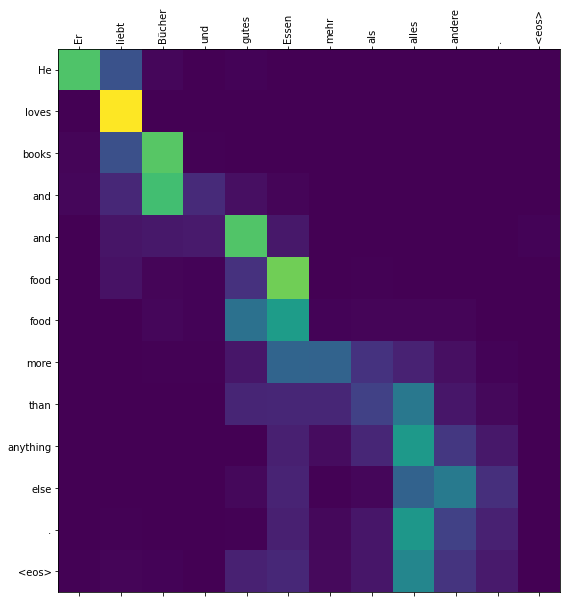

In [18]:
translate(sentences[0], model, cfg, 100, text_transform, vocab_transform, token_transform, device)

TRANSLATION
SOURCE: Mathematik und Physik waren seine liebsten Fächer in der Schule . <eos>
--------------------------------------------------
PREDICTION: unk and physics were the most unk in school school .




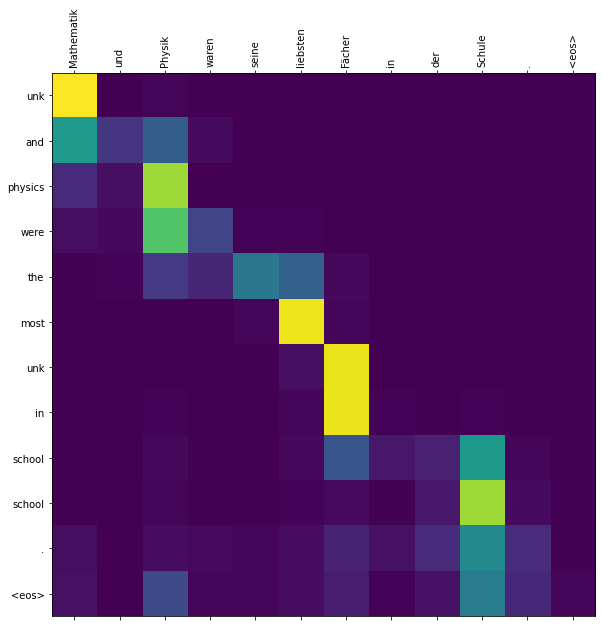

In [19]:
translate(sentences[1], model, cfg, 100, text_transform, vocab_transform, token_transform, device)

TRANSLATION
SOURCE: Peter liebt es mit dem Fahrrad zur Arbeit zu fahren . <eos>
--------------------------------------------------
PREDICTION: Peter was trying to work with the bicycle .




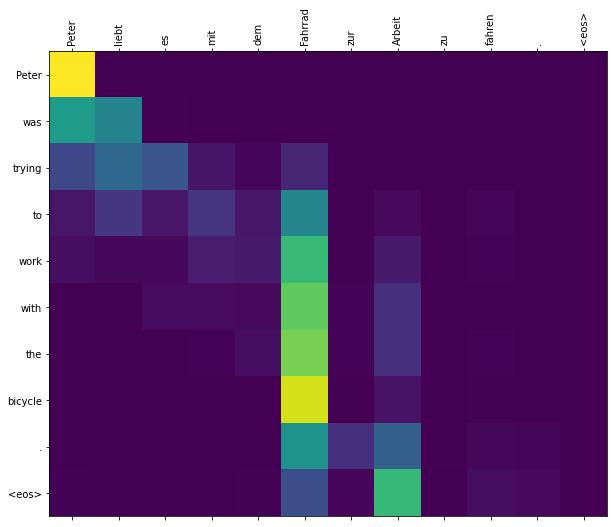

In [20]:
translate(sentences[2], model, cfg, 100, text_transform, vocab_transform, token_transform, device)

TRANSLATION
SOURCE: Künstliche Intelligenz und programmieren macht einfach Spaß . <eos>
--------------------------------------------------
PREDICTION: unk intelligence and and simply simply fun .




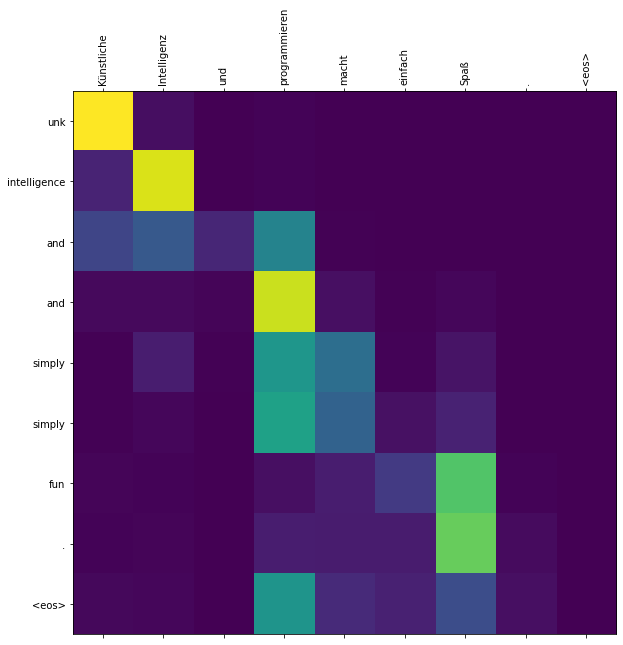

In [21]:
translate(sentences[3], model, cfg, 100, text_transform, vocab_transform, token_transform, device)

# Bleu Score

Down below I evaluate the model on the test set based on the Bleu Score (https://aclanthology.org/P02-1040.pdf) using two different ngram values, 3 & 4. The Bleu Score is often used for evaluation in Neural Machine Translation.

In [22]:
test_iter = get_iter(cfg, split="test")
bleu4 = bleu_score_test(
    test_iter,
    model, 
    cfg, 
    token_transform, 
    text_transform,
    vocab_transform)
bleu4

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1568/1568 [14:45<00:00,  1.77it/s]


16.33

In [23]:
test_iter = get_iter(cfg, split="test")
bleu3 = bleu_score_test(
    test_iter,
    model, 
    cfg, 
    token_transform, 
    text_transform,
    vocab_transform,
    max_n=3,
    weights=[0.33, 0.33, 0.33])
bleu3

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1568/1568 [15:02<00:00,  1.74it/s]


25.19